# A simple program (Yes, this webpage is a .ipynb file!)

The goal of this notebook is to illustrate basic finance computations within a markdown document. There is an analogous .py file, whose results have to be logged. Then, to produce output, you'd have to copy and paste key output into a Word document. This notebook does both at once!

_**The point of this notebook is ONLY illustration! Pay attention to its structure and flow, and get an early glimpse of just a little bit that we can do with `pandas`, `seaborn`, and a few other packages.**_

First, we start by importing key packages...

The core Python language is quite small (nimble and easy to maintain), so we add functionality by using external packages. **The import calls should always be at the top of your code!**

## If you want to run this code (and you should try!)

1. Download the raw [raw unrendered ipynb file here called "02a-a-simple-program.ipynb"](https://github.com/LeDataSciFi/lectures-spr2020/tree/master/content/01/python-files). On Chrome and Firefox, you simply right click the file name and select "Save Link As". Put the file in the same folder with the file you're working on already and then open it in Jupyter.
1. Open **a new/second** terminal/powershell and type `pip install pandas_datareader` 
1. Click the "Kernel" menu above, then "Restart & Clear Output". Now all the results below will disappear.
1. Click the "Cell" menu above, then "Run All"

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr # you might need to install this (see above)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Data

Pandas can acquire a lot of economic data itself, by downloading data from websites through built-in APIs. You'll learn what this means soon!

First, we grab stock prices for three fims. Then we compute daily returns and output some basic statistics.

In [2]:
stock_prices = pdr.get_data_yahoo(['AAPL','MSFT','VZ'], start=2006)
stock_prices = stock_prices.filter(like='Adj Close') # reduce to just columns with this in the name
stock_prices.columns = ['AAPL','MSFT','VZ']

daily_pct_change = pd.DataFrame()
for stock in ['AAPL','MSFT','VZ']:
    daily_pct_change[stock] = stock_prices[stock].pct_change() 

print(daily_pct_change.describe())

              AAPL         MSFT           VZ
count  3537.000000  3537.000000  3537.000000
mean      0.001200     0.000743     0.000508
std       0.019977     0.016698     0.013006
min      -0.179195    -0.117131    -0.080686
25%      -0.008068    -0.007063    -0.006233
50%       0.000959     0.000475     0.000704
75%       0.011256     0.008471     0.007201
max       0.139049     0.186047     0.146324


## Data visualization - Compare the returns of sample firms

The following figure reports all of the pairwise correlations between the sample firms, along with the distribution of each.  

We know from the above table that Apple has the largest mean and standard deviation of the three. The plot type below is useful for seeing if the variables have non-linear relationships, strange outliers, fat tails, or other issues. 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


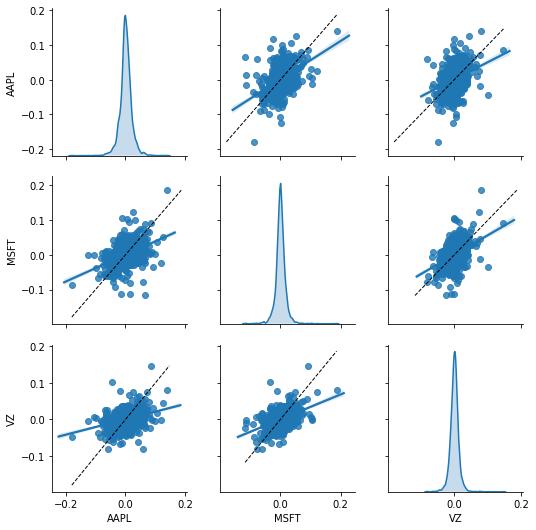

In [3]:
# we need this helper function for a plot

def plot_unity(xdata, ydata, **kwargs):
    '''
    Adds a 45 degree line to the pairplot for plots off the diagonal
    
    Usage: 
    grid=sns.pairplot( <call pairplot as you want >  )
    grid.map_offdiag(plot_unity)
    '''
    mn = min(xdata.min(), ydata.min())
    mx = max(xdata.max(), ydata.max())
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)
     
# compare the return distribution of 3 firms visually...
    
grid = sns.pairplot(daily_pct_change,diag_kind='kde',kind="reg")
grid.map_offdiag(plot_unity) # how cool is that!

## Factor loadings

A core task in asset pricing is calculating the beta of a stock, along with loadings on other factors. The canonical model is the Fama-French 3 factor model, though 4 and 5 factor models are more popular nowadays.

### Merge data on factor loadings with stock return data

We start by grabbing factor returns from Ken French's website, again via pandas API.

In [ ]:
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=2006)[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True) # cleaner name
ff = ff.join(daily_pct_change,how='inner') # merge with stock returns
for stock in ['MSFT','AAPL','VZ']:    
    ff[stock] = ff[stock] * 100 # FF store variables as percents, so convert to that
    ff[stock+'_excess'] = ff[stock] - ff['RF'] # convert to excess returns in prep for regressions
#print(ff.describe()) # ugly...
pd.set_option('display.float_format', lambda x: '%.2f' % x) # show fewer digits
pd.options.display.max_columns = ff.shape[1] # show more columns
print(ff.describe(include = 'all')) # better!

### Now we run the models.

We loop over the stocks, and for each stock, we regress the stock's excess returns on a market (excess) return factor, the size factor "SMB" and the value factor "HML" (see Fama and French (1993)).

In [ ]:
# run the models- 
params=pd.DataFrame()
for stock in ['MSFT','AAPL','VZ']:        
    print('\n\n\n','='*40,'\n',stock,'\n','='*40,'\n')
    model = sm.formula.ols(formula = stock+"_excess ~ mkt_excess + SMB + HML", data = ff).fit()
    print(model.summary())
    params[stock] = model.params.tolist()
params.set_index(model.params.index,inplace=True)   

### Estimated factor loadings

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) # show fewer digits
print(params)

##  Plot the cumulative returns of the three stocks

Finally, I plot the cumulative return from January 1, 2006 until January 2020 by computing for each stock $i$

$cumret(i,T)=\prod^T_{t=0} (1+r_{i,t})$

where $T$ is a date and $t=0$ corresponds to the beginning of the sample.

In [ ]:
cumrets=(daily_pct_change+1).cumprod()-1
plt.clf() # clear the prior plot before starting a new one
sns.lineplot(data=cumrets).set_title("Returns, ex-dividends")
plt.show(grid)

## Lecture flow

Now please [go back](../02_Jupyter_Basics.html#Installing-libraries) and finish the lecture. 